In [17]:
%%capture
pip install 'opendp[polars]'

# Explore opendp==0.14
https://docs.opendp.org/en/stable/getting-started/quickstart.html

In [1]:
import opendp.prelude as dp
import polars as pl

dp.enable_features("contrib")

In [2]:
PATH = "penguin.csv"
#PATH = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
#PATH = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
#PATH = dp.examples.get_france_lfs_path()

In [3]:
lf = pl.scan_csv(PATH, ignore_errors=True)
lf

In [4]:
lf.collect().head(2)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""


# ESSENTIAL

## COUNT

In [138]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=6,
)

In [139]:
## Count rows in frame
query = context.query().select(dp.len())
query.release().collect().item() 

341

In [140]:
## Count rows in column (including nulls)
query = context.query().select(pl.col.sex.dp.len())
query.release().collect().item() 

305

In [141]:
## Count rows in column (excluding nulls)
query = context.query().select(pl.col.sex.dp.count())
query.release().collect().item() 

337

In [142]:
## Count null rows in column (only nulls)
query = context.query().select(pl.col.sex.dp.null_count())
query.release().collect().item() 

9

In [143]:
## Count unique rows in column (including nulls)
query = context.query().select(pl.col.sex.dp.n_unique())
query.release().collect().item() 

0

In [144]:
## Count unique rows in column (including nulls)
query = context.query().select(pl.col.body_mass_g.dp.n_unique())
query.release().collect().item() 

113

In [151]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=6,
)

In [155]:
query_counts = context.query().select([
    dp.len().alias("rows_in_frame"),
    pl.col.sex.dp.len().alias("rows_in_sex"),
    pl.col.sex.dp.count().alias("rows_in_sex_no_null"),
    pl.col.sex.dp.null_count().alias("rows_in_sex_null"),
    pl.col.sex.dp.n_unique().alias("rows_in_sex_unique"),
    pl.col.body_mass_g.dp.n_unique().alias("rows_in_mass_unique"),
])
query_counts.summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""rows_in_frame""","""Frame Length""","""Integer Laplace""",108.0
"""rows_in_sex""","""Length""","""Integer Laplace""",108.0
"""rows_in_sex_no_null""","""Count""","""Integer Laplace""",108.0
"""rows_in_sex_null""","""Null Count""","""Integer Laplace""",108.0
"""rows_in_sex_unique""","""N Unique""","""Integer Laplace""",108.0
"""rows_in_mass_unique""","""N Unique""","""Integer Laplace""",108.0


In [156]:
query_counts.release().collect()

rows_in_frame,rows_in_sex,rows_in_sex_no_null,rows_in_sex_null,rows_in_sex_unique,rows_in_mass_unique
u32,u32,u32,u32,u32,u32
361,512,402,247,42,220


## SUM

In [159]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins=[ 
        dp.polars.Margin(
            max_length=1000 # upper bound number rows (overflow and/or numerical instability)
        ),
    ],
)

In [146]:
query = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .filter(pl.col("flipper_length_mm") >= 185.0)
    .select(
        pl.col.flipper_length_mm.cast(int)
        .fill_null(200)
        .dp.sum(bounds=(185, 250))
    )
)

In [147]:
query.summarize(alpha=0.05)

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""flipper_length_mm""","""Sum""","""Integer Laplace""",3750.0,11234.495992


In [148]:
query.release().collect().item()

6986

## MEAN

In [162]:
query = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .select(
        pl.col.flipper_length_mm.cast(int).dp.sum(bounds=(150, 250)).alias("sum_fl"),
        dp.len().alias("nb_row"),
    )
)

In [163]:
query.release().collect().with_columns(
    mean=pl.col.sum_fl / pl.col.nb_row
) 

sum_fl,nb_row,mean
i64,u32,f64
19520,84,232.380952


In [164]:
context_bounded_dp = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins=[
        dp.polars.Margin(
            max_length=1000,            
            invariant="lengths", # don't protect the total number of records (bounded-DP)
        ),
    ],
)

In [165]:
query = context_bounded_dp.query().select(
    pl.col.flipper_length_mm.cast(int).dp.mean(bounds=(150, 250))
)

In [166]:
query.release().collect().item()

146.11627906976744

## MEDIAN

In [170]:
candidates = list(range(150, 250))

query = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .select(
        pl.col.flipper_length_mm.dp.median(candidates)
    )
)

In [171]:
query.release().collect()

flipper_length_mm
i64
212


## QUANTILES

In [172]:
query_multi_quantiles = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .select(
        pl.col.flipper_length_mm.cast(int)
        .dp.quantile(a, candidates)
        .alias(f"{a}-Quantile")
        for a in [0.25, 0.5, 0.75]
    )
)

In [173]:
query_multi_quantiles.release().collect()  

0.25-Quantile,0.5-Quantile,0.75-Quantile
i64,i64,i64
184,218,205


# GROUPING

## STABLE KEYS (spend delta - only show groups big enough)

In [174]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0, delta=1e-7),
    split_evenly_over=1,
)

In [175]:
query = (
    context.query()
    .group_by("species", "sex")
    .agg(dp.len())
)

In [176]:
tmp_df = query.release().collect()
tmp_df.head(2)

species,sex,len
str,str,u32
"""Gentoo""","""FEMALE""",55
"""Adelie""","""FEMALE""",72


## EXPLICIT KEYS (does not spend delta)

In [177]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0 / 4),
    split_evenly_over=1,
)

In [178]:
query = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .group_by("species", "sex")
    .agg(dp.len())
    .with_keys(tmp_df["species", "sex"])
)

In [179]:
query.release().collect().head(2)

species,sex,len
str,str,u32
"""Adelie""","""FEMALE""",47
"""Gentoo""","""FEMALE""",0


## INVARIANT GROUP KEYS

In [25]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=1.0 / 4),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(by=["species", "sex"], invariant="keys") # group keys when grouped by "species" and "sex" are invariant
    ],
)

In [26]:
query = (
    context.query()
    .group_by("species", "sex")
    .agg(dp.len())
)

In [27]:
query.release().collect().head(2)

species,sex,len
str,str,u32
"""Adelie""","""MALE""",34
"""Chinstrap""","""MALE""",91


## INVARIANT GROUP LENGTHS

In [180]:
# filtering the data within the query results in the margin info being invalidated. 
# One way to work around this limitation is to preprocess your data before passing it into the context
# Not possible in Lomas for now
lf_preprocessed = lf.filter(pl.col("island") == "Torgersen")

In [181]:
context = dp.Context.compositor(
    data=lf_preprocessed,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0, delta=1e-7),
    split_evenly_over=1,
    margins=[
        # total number of responses when grouped by "SEX" is public information
        dp.polars.Margin(
            by=["sex"],
            invariant="lengths",
            max_length=500,
            max_groups=2, # encoding is Male, Female
        )
    ],
)

In [182]:
query_work_hours = (
    context.query()
    .group_by("sex")
    .agg(pl.col.flipper_length_mm.cast(int).dp.mean((150, 250))) # no budget for length as assumed known public info
)

In [183]:
query_work_hours.release().collect().head(2)

sex,flipper_length_mm
str,f64
"""FEMALE""",252.333333
"""MALE""",313.608696


# MICRODATA

## WITH COLUMNS
Expressions passed into .with_columns must be row-by-row, meaning that the expression could be represented as a function applied to each row in the data.

Any new columns added by .with_columns do not (currently) have margin descriptors. For instance, in the above query, any margin descriptors related to HWUSUAL would no longer apply to the new, shadowing, HWUSUAL column after .with_columns.

In [189]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=2.0, delta=1e-6),
    split_evenly_over=3,
    margins=[
        dp.polars.Margin(max_length=1000)
    ],
)

In [190]:
query = (
    context.query()
    .with_columns(
        pl.col.flipper_length_mm.cut(
            breaks=[150, 175, 200, 225],
            left_closed=True,
        ).alias("binned_fl")
    )
    .group_by(pl.col.binned_fl)
    .agg(dp.len())
)

In [191]:
query.release().collect().sort("binned_fl")

binned_fl,len
cat,u32
"""[175, 200)""",174
"""[200, 225)""",130


## SELECT
resolves each passed expression to a column and then returns those columns

## FILTER
.filter uses row-by-row expressions of booleans to mask rows.

Filtering discards all invariants about the group keys and group sizes. Margin descriptors are considered applicable for the input dataset, so a data-dependent filtering renders these invariants invalid.

Otherwise, filtering preserves all other margin descriptors, because filtering only ever removes rows.

In [192]:
query = (
    context.query()
    .with_columns(pl.col.flipper_length_mm.cast(int))
    .filter(pl.col.island == "Torgersen")
    .select(pl.col.flipper_length_mm.dp.sum((150, 250)))
)

In [193]:
print("sum:", query.release().collect().item())  

sum: 7798


## GROUP BY (PRIVATE)
.group_by also resolves each passed expression to a column, and then groups on those columns. must be row-by-row.

In [194]:
query = (
    context.query()
    .group_by(
        pl.col.flipper_length_mm.cut(
            breaks=[150, 175, 200, 225], left_closed=True
        )
    )
    .agg(dp.len())
)

In [195]:
query.release().collect().sort("flipper_length_mm")  

flipper_length_mm,len
cat,u32
"""[175, 200)""",203
"""[200, 225)""",133


## GROUP BY (STABLE)
group_by/agg can also be used earlier in the data pipeline, before the private group_by/agg or select aggregation --> multi group by ? 

appealing because arbitrary expressions can be used in the agg argument, 

but a large amount of data is needed to get reasonable utility.

In [237]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=2.0, delta=1e-6),
    split_evenly_over=3,
    margins=[
        dp.polars.Margin(max_length=1000),
        dp.polars.Margin(
            by=["species"],
            invariant="keys",
            max_length=500,
            max_groups=3,
        ),
        dp.polars.Margin(
            by=["sex"],
            invariant="keys",
            max_length=500,
            max_groups=2,
        ),
        dp.polars.Margin(
            by=["sex", "species"],
            invariant="keys",
            max_length=200,
            max_groups=6,
        )
    ],
)

In [238]:
query = ( # mean of mean
    context.query()
    .group_by("species", "sex")
    .agg(pl.col.flipper_length_mm.mean().alias("mean_fl_species_sex"))
    .select(pl.col.mean_fl_species_sex.cast(int).dp.mean((150, 250)))
)

In [239]:
query.summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""mean_fl_species_sex""","""Sum""","""Integer Laplace""",4500.0
"""mean_fl_species_sex""","""Length""","""Integer Laplace""",18.0


In [240]:
query.release().collect()

mean_fl_species_sex
f64
27.71875


Inform context of number of user in group depending on groupby

In [220]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(
        contributions=[
            dp.polars.Bound(per_group=3),
            # a penguin only belong to one species
            dp.polars.Bound(
                by=[pl.col.species], num_groups=1
            ),
            dp.polars.Bound(
                by=[pl.col.sex], num_groups=1
            ),
        ]
    ),
    privacy_loss=dp.loss_of(epsilon=1.0, delta=1e-7),
    split_evenly_over=4,
    margins=[dp.polars.Margin(max_length=1000)],
)

In [221]:
# does not work to a group by after a group by
query = (
    context.query()
    .group_by("species", "sex")
    .agg(pl.col.flipper_length_mm.mean())
    .group_by(pl.col.sex)
    .agg(
        dp.len(), # must add otherwise # MakeMeasurement("stable key release requires a `dp.len()` expression")
        pl.col.flipper_length_mm.cast(int).dp.mean((150, 250))
    )
)

In [222]:
query.release().collect() # does not work to a group by after a group by

sex,len
str,u32


# MORE PROPERTIES

## BOOLEAN (null, nan, finite)

In [295]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=2.0, delta=1e-6),
    split_evenly_over=3,
    margins=[
        dp.polars.Margin(max_length=1000)
    ],
)

In [247]:
query = (
    context.query()
    .filter(pl.col.island == "Torgersen")
    .filter(pl.col("flipper_length_mm") >= 185.0)
    .filter(pl.col("flipper_length_mm").is_not_null())
    .filter(pl.col("flipper_length_mm").is_not_nan())
    .filter(pl.col("flipper_length_mm").is_finite())
    .select(
        pl.col.flipper_length_mm.cast(int)
        .fill_null(200)
        .dp.sum(bounds=(185, 250))
    )
)

In [248]:
query.release().collect()

flipper_length_mm
i64
8114


## CAST

Cast expressions on grouping columns will void any margin descriptors for those columns.

Useful is when computing a float sum on a large dataset. OpenDP accounts for inexact floating-point arithmetic when computing the float sum, and on data with large bounds and hundreds of thousands of records, this term can dominate the sensitivity.

failed casts do not throw a (data-dependent) exception, instead returning a null. Therefore using this cast operation updates the output domain to indicate that there may potentially be nulls. 

You’ll probably need to apply .fill_null before computing statistics with casted data.

In [250]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=2.0, delta=1e-6),
    split_evenly_over=3,
    margins=[
        dp.polars.Margin(max_length=1000)
    ],
)

In [251]:
context.query().select(pl.col.flipper_length_mm.dp.sum((0, 100))).summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""flipper_length_mm""","""Sum""","""Float Laplace""",450.0


In [252]:
context.query().select(pl.col.flipper_length_mm.cast(int).dp.sum((0, 100))).summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""flipper_length_mm""","""Sum""","""Integer Laplace""",450.0


## DROP/FILL (nan, nulls)

In [254]:
(
    context.query()
    .with_columns(pl.col.bill_length_mm.fill_nan(0.0).fill_null(0.0))
    .with_columns(pl.col.flipper_length_mm.fill_nan(pl.col.bill_length_mm).fill_null(pl.col.bill_length_mm))
    .select(pl.col.flipper_length_mm.dp.sum((0, 100)))
    .summarize()
)

column,aggregate,distribution,scale
str,str,str,f64
"""flipper_length_mm""","""Sum""","""Float Laplace""",450.0


## REPLACE

In [255]:
(
    context.query()
    .select(
        pl.col.body_mass_g.cast(int)
        .replace(old=[5000, None], new=0) # replace 99 and None with 0
        .dp.sum((2000, 7000))
    )
    .summarize()
)

column,aggregate,distribution,scale
str,str,str,f64
"""body_mass_g""","""Sum""","""Integer Laplace""",31500.0


In [256]:
(
    context.query()
    .select(
        pl.col.body_mass_g.cast(int)
        .replace_strict({5000: 0, 6000:0})
        .dp.sum((2000, 7000))
    )
    .summarize()
)

column,aggregate,distribution,scale
str,str,str,f64
"""body_mass_g""","""Sum""","""Integer Laplace""",31500.0


## TO PHYSICAL (underlying representation of categorical)

In [258]:
breaks = [150, 175, 200, 225]
labels = pl.Series("flipper_length_mm", list(range(len(breaks) + 1)), dtype=pl.UInt32)

query = (
    context.query()
    .with_columns(pl.col.flipper_length_mm.cut(breaks=breaks).to_physical())
    .group_by("flipper_length_mm")
    .agg(dp.len())
    .with_keys(pl.LazyFrame([labels]))
)
query.release().collect().sort("flipper_length_mm")

flipper_length_mm,len
u32,u32
0,186
1,7
2,132
3,9
4,0


# SQL

In [296]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=3),
    privacy_loss=dp.loss_of(epsilon=2.0, delta=1e-6),
    split_evenly_over=3,
    margins=[
        dp.polars.Margin(max_length=1000)
    ],
)

In [297]:
expr = pl.sql_expr("AVG(bill_length_mm) AS avg_bill_length_mm")
print(expr)
lf.select(expr).collect().item() # polars only (no opendp)

col("bill_length_mm").mean().alias("avg_bill_length_mm")


43.92192982456141

In [298]:
query = (
    context.query()
    .select(pl.col.bill_length_mm.dp.mean((30.0, 65.0)).alias("avg_bill_length_mm"))
)
query.release().collect()

avg_bill_length_mm
f64
43.226078


In [299]:
query = (
    context.query()
    .select(expr)
)
query.release().collect()

OpenDPException: 
  MakeMeasurement("Expr is not recognized at this time: col("bill_length_mm").mean(). If you would like to see this supported, please file an issue.")

In [283]:
expr = pl.sql_expr("VAR(bill_length_mm) AS var_bill_length_mm")
print(expr)
lf.select(expr).collect().item() # polars only (no opendp)

col("bill_length_mm").var().alias("var_bill_length_mm")


29.80705432937182

In [290]:
query = (
    context.query()
    .select(pl.col.bill_length_mm.dp.var((30.0, 65.0)).alias("var_bill_length_mm"))
)
query.release().collect()

AttributeError: 'DPExpr' object has no attribute 'var'

In [300]:
query = (
    context.query()
    .select(pl.col.bill_length_mm.dp.std((30.0, 65.0)).alias("std_bill_length_mm"))
)
query.release().collect()

AttributeError: 'DPExpr' object has no attribute 'std'

# LINEAR REGRESSION

In [346]:
import matplotlib.pyplot as plt
import numpy as np

In [303]:
dp.enable_features("floating-point", "contrib", "honest-but-curious")

In [333]:
lin_reg = dp.sklearn.linear_model.LinearRegression(
    dp.max_divergence(),
    x_bounds=[(13.0, 23.0)],
    y_bounds=(30.0, 65.0),
    scale=1,
)

In [337]:
df = lf.drop_nulls(["bill_depth_mm", "bill_length_mm"]).collect()
X = df["bill_depth_mm"].to_numpy().reshape(-1, 1) 
y = df["bill_length_mm"].to_numpy()

In [338]:
lin_reg = lin_reg.fit(X=X, y=y)

In [339]:
lin_reg.score(X,y)

0.055249851862374744

In [341]:
lin_reg.intercept_, lin_reg.coef_

(np.float64(55.0673697719197), array([-0.64983556]))

In [347]:
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = lin_reg.predict(x_line)

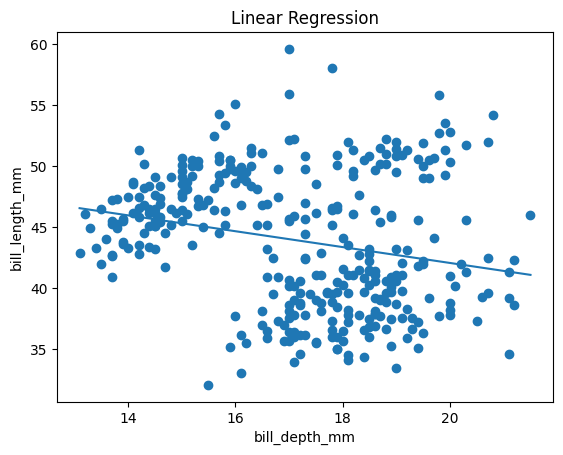

In [348]:
plt.title("Linear Regression")
plt.scatter(X, y)
plt.plot(x_line, y_pred)
plt.xlabel("bill_depth_mm")
plt.ylabel("bill_length_mm")
plt.show()